In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from dotenv import load_dotenv

load_dotenv("../.env")

OPEN_WEATHER_API_KEY = os.getenv("OPEN_WEATHER_API_KEY")
EST_APOGEE_LAT, EST_APOGEE_LON = "37.8812778", "-74.97897222222223"

In [35]:
poll_hist = requests.get(f"""http://api.openweathermap.org/data/2.5/air_pollution/history?lat={EST_APOGEE_LAT}&lon={
    EST_APOGEE_LON}&start=660852034&end=1702231234&appid={OPEN_WEATHER_API_KEY}""")
poll_hist

<Response [200]>

In [36]:
poll_hist_data = poll_hist.json()["list"]
poll_hist_data[0]

{'main': {'aqi': 2},
 'components': {'co': 226.97,
  'no': 0,
  'no2': 1.48,
  'o3': 80.11,
  'so2': 1.33,
  'pm2_5': 1.07,
  'pm10': 1.38,
  'nh3': 0.17},
 'dt': 1606266000}

In [37]:
# Open Weather Map's Air Pollution API provides the result in Microgram per cubic meter
# However, our sensor uses parts per billion, so we need to translate the components accordingly

# Concentration (ppb) = 24.45 x concentration (µg/m3) ÷ molecular weight 

def clean_pollution_record(record):
    return {
        "date": pd.to_datetime(record["dt"], unit="s"),
        "air_quality_index":record["main"]["aqi"],
        "carbon_monoxide": (24.45 * float(record["components"]["co"])) / 28.0,
        "nitric_monoxide": (24.45 * float(record["components"]["no"])) / 30.01,
        "nitrogen_dioxide": (24.45 * float(record["components"]["no2"])) / 46.01,
        "ozone": (24.45 * float(record["components"]["o3"])) / 48,
        "sulfur_dioxide": (24.45 * float(record["components"]["so2"])) / 64.07,
        "particulate_matter_2-5":record["components"]["pm2_5"],
        "particulate_matter_10":record["components"]["pm10"],
        "ammonia":record["components"]["nh3"]
    }
    
cleaned_poll_hist_data = [ clean_pollution_record(record) for record in poll_hist_data ]
poll_df = pd.DataFrame(cleaned_poll_hist_data)
poll_df

,date,air_quality_index,carbon_monoxide,nitric_monoxide,nitrogen_dioxide,ozone,sulfur_dioxide,particulate_matter_2-5,particulate_matter_10,ammonia
0,2020-11-25 01:00:00,2,198.193446,0.000000,0.786481,40.806031,0.507546,1.07,1.38,0.17
1,2020-11-25 02:00:00,2,198.193446,0.000000,0.701456,41.534438,0.465569,0.96,1.26,0.13
2,2020-11-25 03:00:00,2,195.285643,0.000000,0.643002,42.262844,0.442672,0.88,1.19,0.10
3,2020-11-25 04:00:00,2,195.285643,0.000000,0.616431,42.262844,0.431224,0.84,1.18,0.07
4,2020-11-25 05:00:00,2,198.193446,0.000000,0.643002,41.896094,0.442672,0.89,1.30,0.05
...,...,...,...,...,...,...,...,...,...,...
26389,2023-12-10 14:00:00,2,192.369107,0.008147,0.356042,48.090094,0.129749,2.43,4.04,0.00
26390,2023-12-10 15:00:00,2,192.369107,0.016295,0.356042,48.818500,0.125933,2.40,3.99,0.00
26391,2023-12-10 16:00:00,2,189.452571,0.016295,0.361356,48.818500,0.122116,2.39,4.06,0.00
26392,2023-12-10 17:00:00,2,189.452571,0.016295,0.382612,48.818500,0.125933,2.74,4.94,0.00


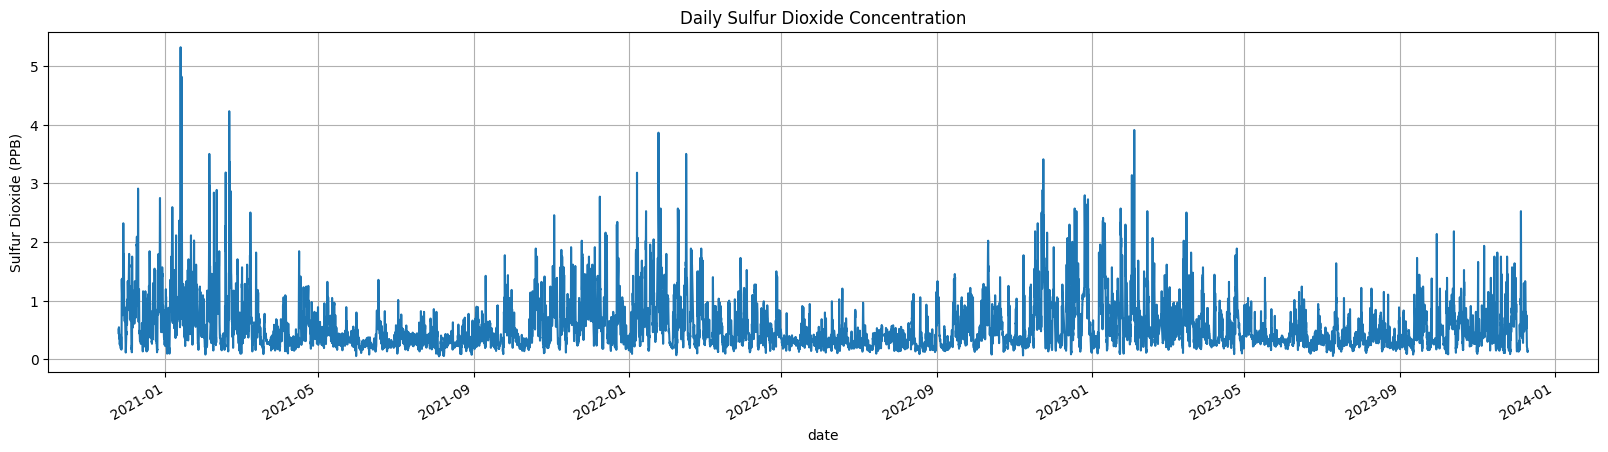

In [38]:
poll_df.set_index("date").sulfur_dioxide.plot(figsize=(20,5), title="Daily Sulfur Dioxide Concentration")
# plt.ylim(bottom=0, top=5)
plt.ylabel("Sulfur Dioxide (PPB)")
plt.grid(True)
plt.show()

In [39]:
iandt_df = poll_df.loc[poll_df.date.dt.month == 6].reset_index(drop=True).set_index("date")
launch_df = poll_df.loc[poll_df.date.dt.month == 8].reset_index(drop=True).set_index("date")

In [40]:
iandt_df.sulfur_dioxide.resample("Y").median()

date
2021-12-31    0.270946
2022-12-31    0.299567
2023-12-31    0.347269
Freq: A-DEC, Name: sulfur_dioxide, dtype: float64

In [41]:
launch_df.sulfur_dioxide.resample("Y").median()

date
2021-12-31    0.278578
2022-12-31    0.269038
2023-12-31    0.351085
Freq: A-DEC, Name: sulfur_dioxide, dtype: float64

In [42]:
launch_df.sulfur_dioxide.describe()

count    2232.000000
mean        0.336820
std         0.175837
min         0.049610
25%         0.217520
50%         0.297659
75%         0.404511
max         1.217348
Name: sulfur_dioxide, dtype: float64

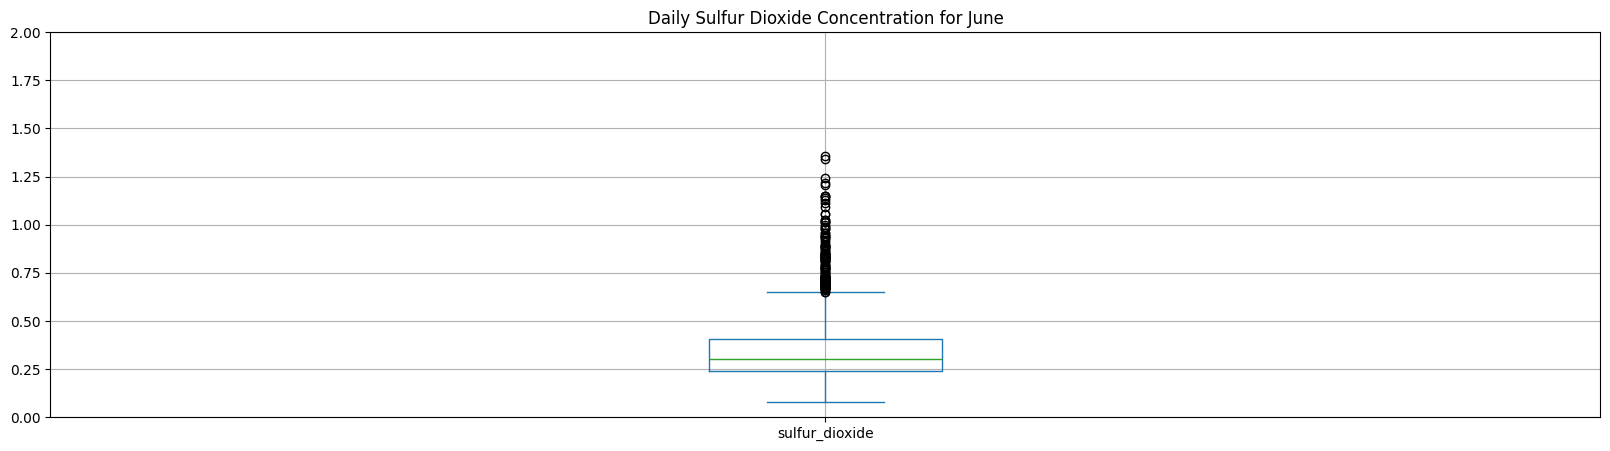

In [43]:
iandt_df.sulfur_dioxide.plot.box(figsize=(20,5), title="Daily Sulfur Dioxide Concentration for June")
plt.ylim(bottom=0, top=2)
plt.grid(True)
plt.show()


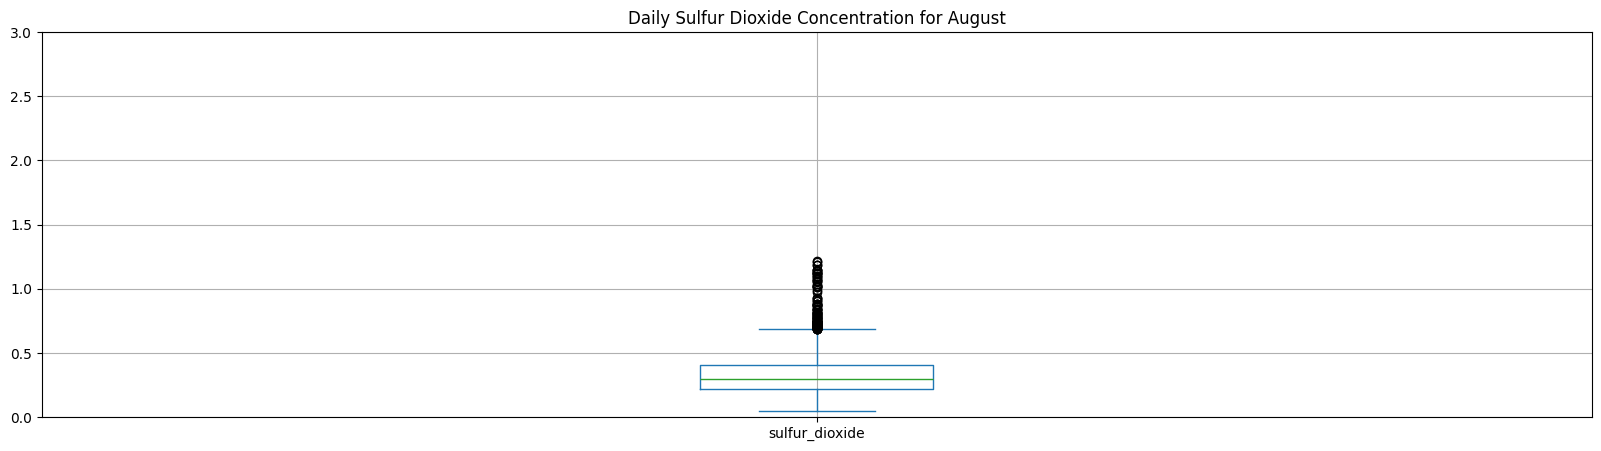

In [44]:
launch_df.sulfur_dioxide.plot.box(figsize=(20,5), title="Daily Sulfur Dioxide Concentration for August")
plt.ylim(bottom=0, top=3)
plt.grid(True)
plt.show()